# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle
from sklearn import metrics

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision import datasets, models, transforms

# Download data

In [5]:
path = Path('/home/jupyter/temp/data_new/')
path.mkdir(exist_ok=True)

In [6]:
# download the files from kaggle, you need a kaggle account and api key
! kaggle competitions download -c histopathologic-cancer-detection -f train.zip -p {path}  
! kaggle competitions download -c histopathologic-cancer-detection  -f train_labels.csv -p {path} 
! kaggle competitions download -c histopathologic-cancer-detection  -f test.zip -p {path}
! kaggle competitions download -c histopathologic-cancer-detection  -f sample_submission.csv -p {path}

100%|██████████████████████████████████████▉| 4.98G/4.98G [00:59<00:00, 199MB/s]
100%|██████████████████████████████████████| 4.98G/4.98G [00:59<00:00, 89.5MB/s]
 98%|█████████████████████████████████████▏| 5.00M/5.10M [00:00<00:00, 19.9MB/s]
100%|██████████████████████████████████████| 5.10M/5.10M [00:00<00:00, 20.2MB/s]
 99%|██████████████████████████████████████▊| 1.30G/1.30G [00:16<00:00, 112MB/s]
100%|██████████████████████████████████████| 1.30G/1.30G [00:16<00:00, 83.8MB/s]
  0%|                                               | 0.00/1.33M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 1.33M/1.33M [00:00<00:00, 127MB/s]


In [7]:
! unzip -q -n {path}/train.zip -d {path/'train'}
! unzip -q -n {path}/test.zip -d {path/'test'}
! unzip -q -n {path}/sample_submission.csv.zip -d {path}
! unzip -q -n {path}/train_labels.csv.zip -d {path}

In [11]:
# change the permissions
! chmod 777 './data_new/train_labels.csv'
! chmod 777 './data_new/sample_submission.csv'

In [5]:
# import zipfile
# with zipfile.ZipFile("./data/train_labels.csv.zip","r") as zip_ref:
#     zip_ref.extractall("./data/train_csv")

# import zipfile
# with zipfile.ZipFile("./data/train.zip","r") as zip_ref:
#     zip_ref.extractall("./data/train")

# import zipfile
# with zipfile.ZipFile("./data/test.zip","r") as zip_ref:
#     zip_ref.extractall("./data/test")

In [8]:
# list no of files in folder
! ls ./data_new/test/ | wc -l

57458


In [9]:
# make sure that all fils are with .tif extension
len(glob.glob1("./data_new/test/","*.tif"))

57458

# Setup

In [4]:
CROP_SIZE = 68
SEED = 42
np.random.seed(SEED)

DATA_DIR = './data_new'
# TRAIN_DATA  = DATA_DIR+'train'
# VAL_DATA = DATA_DIR+'val'
DATA_DIR = Path(DATA_DIR)
TEST_DIR = Path('./data_new/test')
ORG_SIZE=96
LABELS = './data_new/train_labels.csv'
SAMPLE_SUB = './data_new/sample_submission.csv'
SUBMISSIONS_PATH = './submissions/'
TRAIN_DIR = './data_new/train/'
MODEL_PATH = 'base_rn34_2'

# Analysis

## About data

**220k training images and 57k evaluation images**. The dataset is a subset of the **PCam dataset** and the only difference between these two is that all duplicate images have been removed. The PCam dataset is derived from the Camelyon16 Challenge dataset which contains 400 H&E stained whole slide images of sentinel lymph node sections that were acquired and digitized at 2 different centers using a 40x objective. The PCam's dataset including this one uses 10x undersampling to increase the field of view, which gives the resultant pixel resolution of 2.43 microns.

According to the data description, there is a 50/50 balance between positive and negative examples in the training and test splits. However, the training **distribution seems to be 60/40 (negatives/positives)**. A positive label means that there is at least **one pixel of tumor tissue in the center region (32 x 32px) of the image**. Tumor tissue in the outer region of the patch does not influence the label. This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region.

In [12]:
df = pd.read_csv(path/'train_labels.csv',engine='python')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
train_df = pd.read_csv(LABELS).set_index('id')
train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)
print("Number of positive samples = {:.4f}%".format(np.count_nonzero(train_labels)*100/len(train_labels)))
test_names = [f.replace(".tif","") for f in os.listdir(TEST_DIR)]
tr_n, val_n = train_test_split(train_names, test_size=0.15, random_state=SEED)
print(len(tr_n), len(val_n))

Number of positive samples = 40.5031%
187021 33004


In [7]:
# got from other kernels of this competition 
channel_mean = [0.70185, 0.54483, 0.69568]
channel_std = [0.22262, 0.26757, 0.1995 ]

## Visualize data

In [40]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

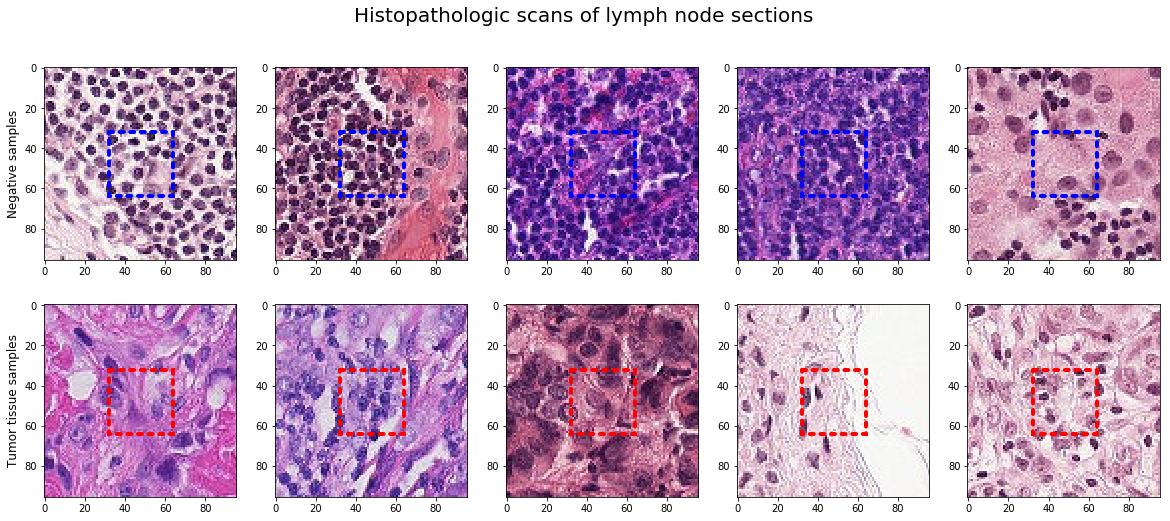

In [29]:
# random sampling
shuffled_data = shuffle(df)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(TRAIN_DIR, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(TRAIN_DIR, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

# Model

## Preprocessing and data augmentation

The augmentations, we gonna use for this dataset:

* random rotation
* random resize crop
* random flip (horizontal and vertical both)
* random lighting
* random zoom

In [6]:
test_items = ItemList.from_folder(path/'test')

In [7]:
src = (ImageItemList.from_csv(DATA_DIR/'train',csv_name='../train_labels.csv', suffix='.tif') \
        .random_split_by_pct(0.15) \
        .label_from_df(cols='label')
        .add_test(test_items)) 

In [8]:
# cntr_crp = zoom_crop(scale=1.25,do_rand=False)
# tfms = get_transforms(flip_vert=True, max_rotate=180, max_lighting=0.2, max_zoom=1.05, p_lighting=0.5, p_affine=0.5, max_warp=0)

In [10]:
def _crop_image_points(x, size, row_pct=0.5, col_pct=0.5):
    h,w = x.size
    rows,cols = listify(size, 2)
    x.flow.flow.mul_(torch.Tensor([w/cols, h/rows])[None])
    row = int((h-rows+1) * row_pct)
    col = int((w-cols+1) * col_pct)
    x.flow.flow.add_(-1 + torch.Tensor([w/cols-2*col/cols, h/rows-2*row/rows])[None])
    x.size = (rows, cols)
    return x

def _crop_default(x, size, row_pct:uniform=0.5, col_pct:uniform=0.5):
    "Crop `x` to `size` pixels. `row_pct`,`col_pct` select focal point of crop."
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows+1) * row_pct)
    col = int((x.size(2)-cols+1) * col_pct)
    return x[:, row:row+rows, col:col+cols].contiguous()

def _crop(x, size=68, row_pct:uniform=0.5, col_pct:uniform=0.5):
    f_crop = _crop_image_points if isinstance(x, ImagePoints) else _crop_default
    return f_crop(x, size, row_pct, col_pct)
cntr_crop = TfmPixel(_crop)

In [11]:
tfms = get_transforms(flip_vert=True, max_rotate=180, max_lighting=0.2, max_zoom=1, p_lighting=0.5,
                      p_affine=0.5, max_warp=0, xtra_tfms = [cntr_crop()])

## Baseline model, ResNet18, current model ResNet50

In [12]:
baseline_tfms = get_transforms(flip_vert=True, max_rotate=180, max_lighting=0.2, max_zoom=1, p_lighting=0,
                      p_affine=0, max_warp=0)

data =(src.transform(baseline_tfms, size=96) \
        .databunch().normalize(imagenet_stats))

# data.show_batch(3)

In [13]:
base_arch = models.resnet18
base_learn = create_cnn(data, base_arch, metrics=[error_rate,accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


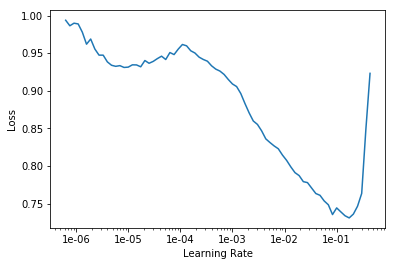

In [254]:
# find learning rate 
base_learn.lr_find()
base_learn.recorder.plot()

In [255]:
# we choose the learning rate at sharp decline in above plot 
lr = 0.003
base_learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.273245,0.242898,0.097627,0.902373


In [256]:
base_learn.save('stage-1_base_rn18')
# learn.load('stage-1-rn18-0.005');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


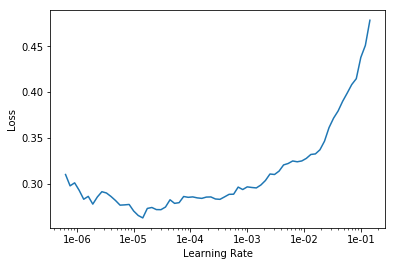

In [257]:
base_learn.unfreeze()
base_learn.lr_find()
base_learn.recorder.plot()

In [258]:
base_learn.fit_one_cycle(3, slice(1e-3, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.210231,0.214283,0.085477,0.914523
2,0.149287,0.133328,0.047814,0.952186
3,0.119529,0.107110,0.039057,0.960943


In [259]:
base_learn.save('stage-2-rn34_2')

# Model performance on Validation dataset

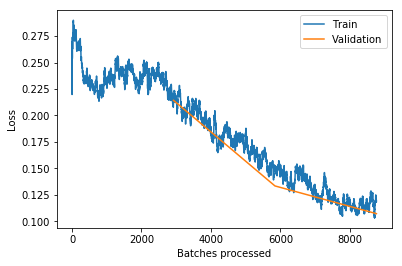

In [262]:
# plot the loss
base_learn.recorder.plot_losses()

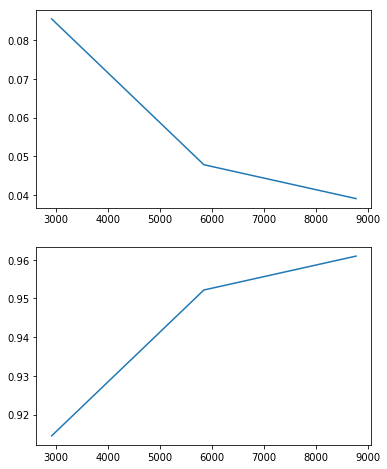

In [263]:
base_learn.recorder.plot_metrics()

In [264]:
interp = ClassificationInterpretation.from_learner(base_learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

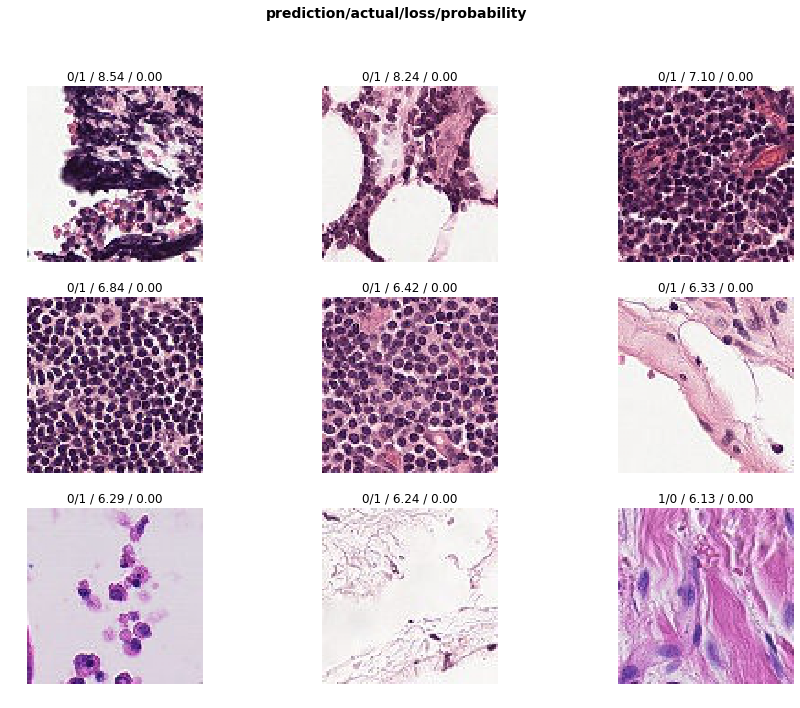

In [265]:
# plot top losses
interp.plot_top_losses(9, figsize=(15,11))

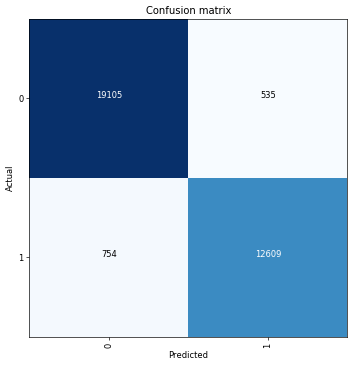

In [266]:
# confusion matrix
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## ROC curve and AUC

In [267]:
# Predict the validation set
preds, orig = base_learn.get_preds()

In [268]:
probs, pred_cls = preds.max(dim=1)

In [269]:
# Compute ROC curve
fpr, tpr, thresholds = metrics.roc_curve(orig, pred_cls, pos_label=1)

# Compute ROC area
roc_auc = metrics.auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9581676092740495


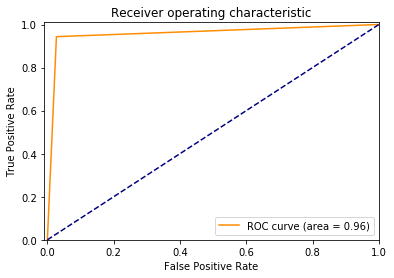

In [270]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Prediction on test dataset 

In [15]:
base_learn.load('stage-2-rn34_2');

In [17]:
# preds_t,y_t = learn.TTA(ds_type=data.test_ds)
preds_t,y_t = base_learn.get_preds(ds_type=DatasetType.Test)

In [18]:
pred_probs, preds_t_cls = preds_t.max(dim=1)

## Prepare submission

In [19]:
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)
pred_list = [p for p in preds_t_cls.numpy()]
test_fnames = [path.stem for path in data.test_dl.dataset.x.items]
pred_dic = dict((key, value) for (key, value) in zip(test_fnames,pred_list))
pred_list_cor = [pred_dic[id] for id in sample_list]
df = pd.DataFrame({'id':sample_list,'label':pred_list_cor})
submission_path = SUBMISSIONS_PATH + '{0}_submission.csv'.format(MODEL_PATH)
df.to_csv(submission_path, header=True, index=False)